# Two-phase Cahn-Hilliard solvers

In [1]:
import voxelsss as vox
import numpy as np

Create voxel fields object which is large enough to compare computation times. Also create some random noise as the inital condition of the concentration field.

In [2]:
Nx, Ny, Nz = [100, 100, 100]
vf = vox.VoxelFields(Nx, Ny, Nz, domain_size=(Nx, Ny, Nz))
noise = 0.5 + 0.1*np.random.rand(Nx, Ny, Nz)
noise[0,:,:] = 0.1

### Wall time comparison for periodic solvers

The Periodic Cahn-Hilliard solver class explores three implementations for time-stepping:
 - 'explicit': standard explicit Euler scheme
 - 'full_FFT': semi-implicit timestepping in Fourier space
 - 'mixed_FFT': semi-implicit timestepping where the divergence in computed real space while the time-increment is updated in Fourier space

All spatial gradients are resolved with second order finite difference stencils.
Additionally, the float precision plays an immense roll for the runtime on a GPU, as only single precision is naturally supported.

Define same end time for all simulations

In [3]:
end_time = 100

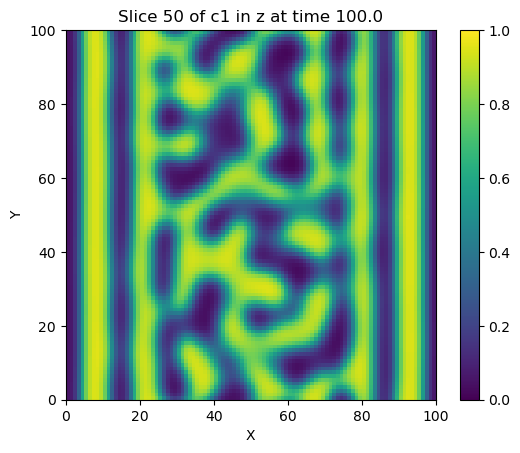

Wall time: 47.1732 s after 20000 iterations (0.0024 s/iter)
GPU-RAM currently allocated 21.21 MB (65.01 MB reserved)
GPU-RAM maximally allocated 41.95 MB (65.01 MB reserved)


In [4]:
vf.add_field("c1", noise)

dt = 0.005
sim = vox.PeriodicCahnHilliardSolver(vf, 'c1', device='cuda')
sim.solve(method = 'explicit', \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

Now, set the float precision to double. Note that the voxelField object will inherit its float precision to the solver i.e. all pytorch tensors will have the same precision.

In [5]:
vf.precision = np.float64

...and perform the same simulation again. Note that in this case, the ``add_field`` is used to initialize a new field ``c2`` from the initial noise field before the start of the simulation.

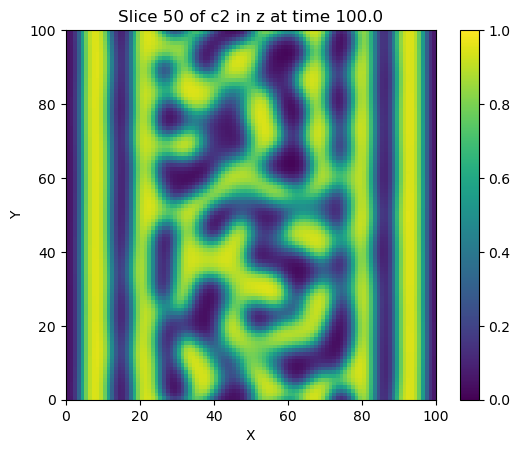

Wall time: 269.954 s after 20000 iterations (0.0135 s/iter)
GPU-RAM currently allocated 53.96 MB (174.06 MB reserved)
GPU-RAM maximally allocated 120.29 MB (174.06 MB reserved)


In [6]:
vf.add_field("c2", noise)

dt = 0.005
sim = vox.PeriodicCahnHilliardSolver(vf, 'c2', device='cuda')
sim.solve(time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

The simulation time on a GPU will not simply be double the time but actually much more. Before continuing, let's set the precision back to float32

In [7]:
vf.precision = np.float32

### Semi-implicit FFT solver

The semi-implicit timestepping schemes allow for much larger timesteps.

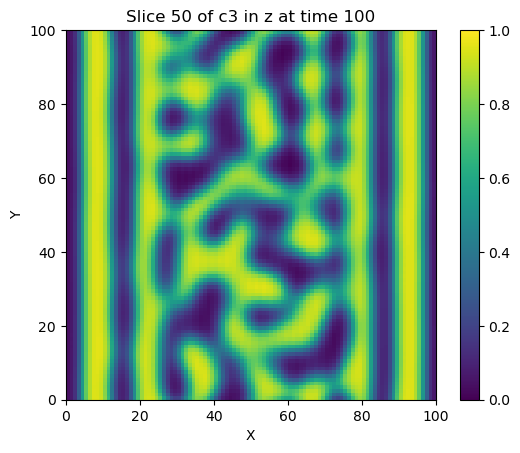

Wall time: 1.376 s after 100 iterations (0.0138 s/iter)
GPU-RAM currently allocated 54.82 MB (174.06 MB reserved)
GPU-RAM maximally allocated 97.05 MB (174.06 MB reserved)


In [8]:
vf.add_field("c3", noise)

dt = 1
sim = vox.PeriodicCahnHilliardSolver(vf, 'c3', device='cuda')
sim.solve(method='full_FFT', \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

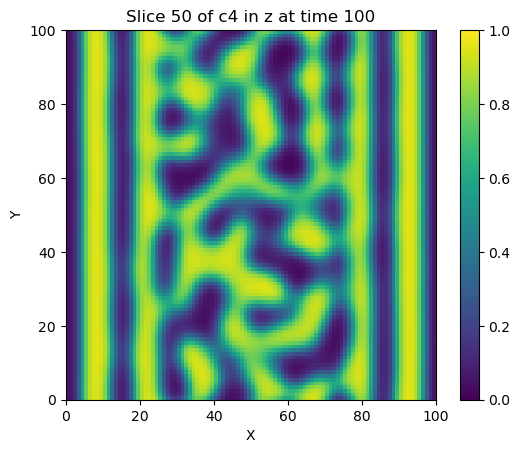

Wall time: 1.1664 s after 100 iterations (0.0117 s/iter)
GPU-RAM currently allocated 28.78 MB (174.06 MB reserved)
GPU-RAM maximally allocated 63.55 MB (174.06 MB reserved)


In [9]:
vf.add_field("c4", noise)

dt = 1
sim = vox.PeriodicCahnHilliardSolver(vf, 'c4', device='cuda')
sim.solve(method='mixed_FFT', \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

Note that the second implementation of mixed FFT is faster and also consumes less RAM space compared to the full FFT variant. This is extremely convenient as rapid prototyping of code is easier in real space and the transfer from explicit Euler to the mixed FFT formulation is straightforward.

### Mixed Dirichlet/Neumann + periodic solvers

Instead of having periodic boundary conditions in all three directions, it is possible to mix Dirichlet or Neumann boundary conditions in the x-direction with periodic boundaries in the y- and z-direction.

In [10]:
Nx, Ny, Nz = [100, 100, 100]
vf = vox.VoxelFields(Nx, Ny, Nz, domain_size=(Nx, Ny, Nz))
noise = 0.5 + 0.1*np.random.rand(Nx, Ny, Nz)
noise[0,:,:] = 0.1
end_time = 100

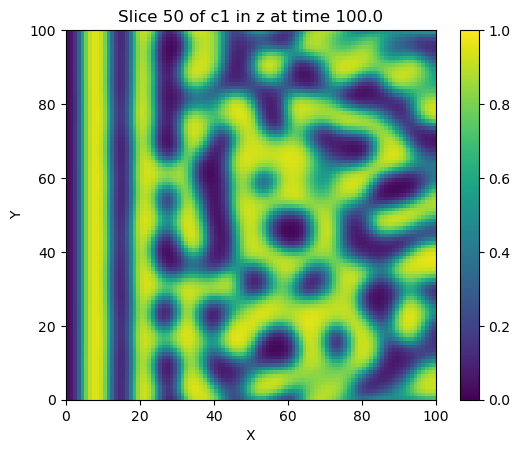

Wall time: 6.3625 s after 1000 iterations (0.0064 s/iter)
GPU-RAM currently allocated 66.53 MB (174.06 MB reserved)
GPU-RAM maximally allocated 134.51 MB (174.06 MB reserved)


In [11]:
vf.add_field("c1", noise)

dt = 0.1
sim = vox.MixedCahnHilliardSolver(vf, 'c1', mode='neumann', device='cuda')
sim.solve(method = 'mixed_FFT', A=0.1, \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

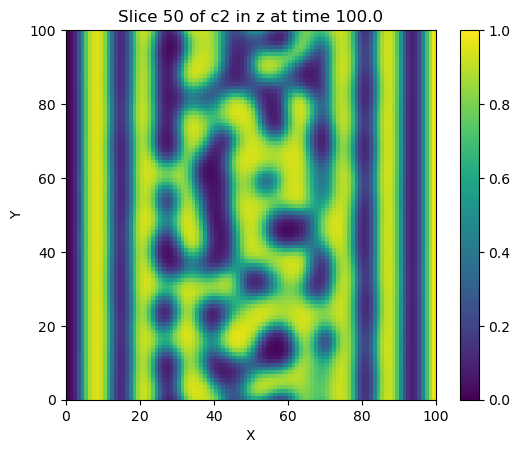

Wall time: 6.5156 s after 1000 iterations (0.0065 s/iter)
GPU-RAM currently allocated 67.25 MB (174.06 MB reserved)
GPU-RAM maximally allocated 137.78 MB (174.06 MB reserved)


In [12]:
vf.add_field("c2", noise)

dt = 0.1
sim = vox.MixedCahnHilliardSolver(vf, 'c2', mode='dirichlet', device='cuda')
sim.solve(method = 'mixed_FFT', bcs=(0,1), A=0.1, \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))

As discussed in the example notebook for voxelFields, the staggered_x convention shifts all grid points by $\Delta x/2$ such that nodes are actually located on the domain boundary at $x=0$ and $x=L_x$. We therefore increase the number of points in x by one and make sure that the domain size stays the same.

In [13]:
Nx, Ny, Nz = [101, 100, 100]
vf = vox.VoxelFields(Nx, Ny, Nz, domain_size=(Nx-1, Ny, Nz), convention='staggered_x')

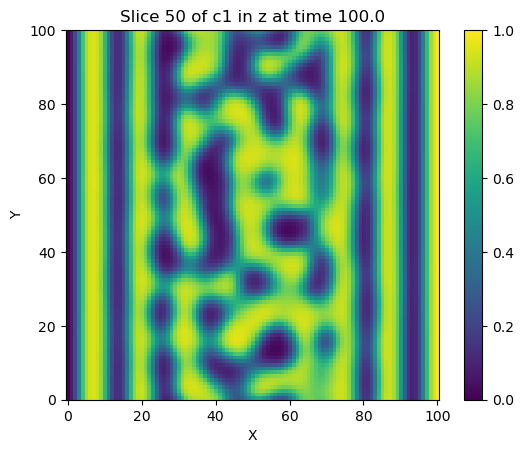

Wall time: 6.2916 s after 1000 iterations (0.0063 s/iter)
GPU-RAM currently allocated 72.65 MB (190.84 MB reserved)
GPU-RAM maximally allocated 138.76 MB (190.84 MB reserved)


In [14]:
vf.add_field("c1", np.concatenate((noise, noise[0:1,:,:]), axis=0))

dt = 0.1
sim = vox.MixedCahnHilliardSolver(vf, 'c1', mode='dirichlet', device='cuda')
sim.solve(method = 'mixed_FFT', bcs=(0,1), A=0.1, \
          time_increment=dt, frames=10, max_iters=int(end_time/dt), \
          verbose='plot', vtk_out=None, plot_bounds=(0,1))